In [25]:
import sys,glob,csv
sys.path.append('/home/simon/git/burns/code/')

In [26]:
data_file = '/home/simon/git/burns/notebooks/spreadsheets/both_v_both/both_v_both_log_1e-05_tus.csv'
rows = []
with open(data_file,'r') as f:
    reader = csv.reader(f)
    heads = reader.next()
    for line in reader:
        rows.append(line)
print heads[-3]

n_blank


In [30]:
file_names = heads[1:-3]
class1 = file_names[:26]
class2 = file_names[26:]

sub_data = []
sub_row = []
fmz = []
for row in rows:
    n_present = 0
    sub_row = []
    for name in class1 + class2:
        pos = heads.index(name)
        da = row[pos]
        if da == 'nan':
            sub_row.append(0.0)
        else:
            n_present += 1
            sub_row.append(float(da))
    n_blank = int(row[-3])
    if n_present >= 3 and n_blank <= 0:
        sub_data.append(sub_row)
        fmz.append(float(row[0]))

In [31]:
from sklearn.model_selection import StratifiedKFold
import numpy as np


In [32]:
X = np.array(sub_data).T
print X.shape
y = [0 for c in class1] + [1 for c in class2]
y = np.array(y)

(44, 496)


In [33]:
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X,y)

3

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score,roc_curve
tpr = []
fpr = []
totr = 0
for train_index,test_index in skf.split(X,y):
    s = SVC(gamma = 'auto',probability = True)
    s.fit(X[train_index],y[train_index])
    preds = s.predict_proba(X[test_index])
    r = roc_auc_score(y[test_index],preds[:,1])
    a,b,t = roc_curve(y[test_index],preds[:,1])
    tpr.append(a)
    fpr.append(b)
    totr += r
print totr/(1.0*3)

0.844135802469


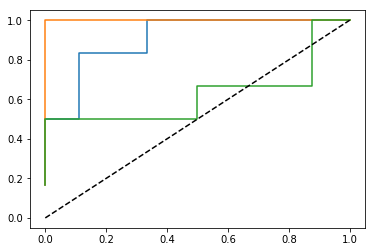

In [35]:
import pylab as plt
%matplotlib inline
for a,b in zip(tpr,fpr):
    plt.plot(a,b)
plt.plot([0,1],[0,1],'k--')

In [36]:
class1_id = [['MSS1a','MSS1b'],
             ['MSS2a','MSS2b'],
             ['MSS3a','MSS3b'],
             ['MSS4a','MSS4b'],
             ['MSS5a','MSS5b'],
             ['MSS6a','MSS6b'],
             ['MSS13a','MSS13b']]
class2_id = [['MSS10a','MSS10b'],['MSS11a','MSS11b'],['MSS14a','MSS14b']]
train_index = []
test_index = []
rp = []
yt = []
p = []
for i in class1_id+class2_id:
    print i
    train_index = []
    test_index = []
    for j,n in enumerate(class1+class2):
        if n.startswith(i[0]) or n.startswith(i[1]):
            test_index.append(j)
        else:
            train_index.append(j)
    
    s = SVC(C = 1e6,gamma = 'auto',probability = True)
    s.fit(X[train_index],y[train_index])
    preds = s.predict_proba(X[test_index])
    p += list(preds[:,1])
    raw_preds = list(s.predict(X[test_index]))
    rp += raw_preds
    yt += list(y[test_index])
    print raw_preds,y[test_index]
    acc = sum([1 if a==b else 0 for a,b in zip(raw_preds,y[test_index])])/(1.0*len(raw_preds))
    print acc
#     r = roc_auc_score(y[test_index],preds[:,1])
#     print r
#     break

['MSS1a', 'MSS1b']
[0, 0] [0 0]
1.0
['MSS2a', 'MSS2b']
[0, 0] [0 0]
1.0
['MSS3a', 'MSS3b']
[0, 0] [0 0]
1.0
['MSS4a', 'MSS4b']
[0, 0] [0 0]
1.0
['MSS5a', 'MSS5b']
[0, 1, 1, 1, 0, 0, 0, 0] [0 0 0 0 0 0 0 0]
0.625
['MSS6a', 'MSS6b']
[0, 0] [0 0]
1.0
['MSS13a', 'MSS13b']
[0, 0, 0, 1, 0, 0, 1, 0] [0 0 0 0 0 0 0 0]
0.75
['MSS10a', 'MSS10b']
[1, 1] [1 1]
1.0
['MSS11a', 'MSS11b']
[1, 1, 1, 1, 1, 1, 1, 0] [1 1 1 1 1 1 1 1]
0.875
['MSS14a', 'MSS14b']
[1, 1, 1, 1, 1, 0, 0, 0] [1 1 1 1 1 1 1 1]
0.625


0.760683760684


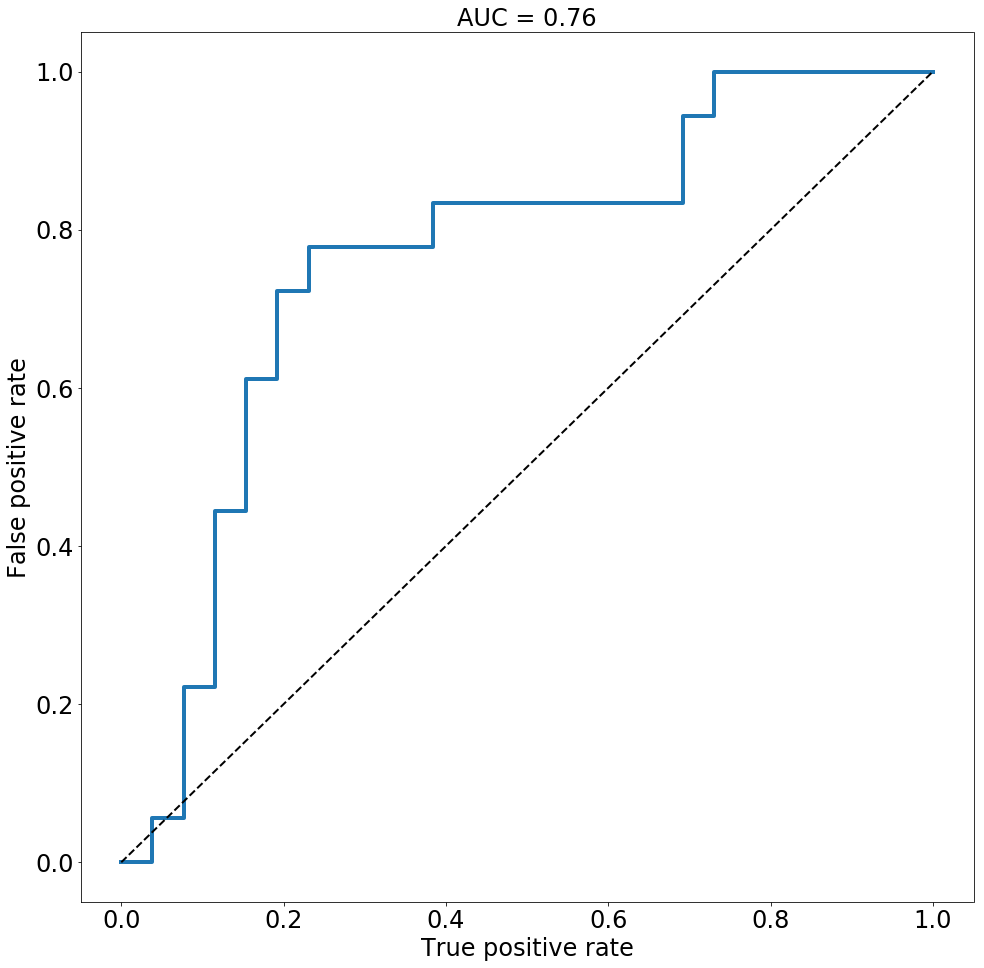

In [37]:
r = roc_auc_score(yt,p)
tpr,fpr,thresh = roc_curve(yt,p)
plt.figure(figsize=(16,16))
plt.plot(tpr,fpr,linewidth=4)
plt.plot([0,1],[0,1],'k--',linewidth=2)
plt.xticks(np.arange(0.0,1.1,0.2),fontsize=24)
plt.yticks(np.arange(0.0,1.1,0.2),fontsize=24)
plt.xlabel('True positive rate',fontsize=24)
plt.ylabel('False positive rate',fontsize=24)
plt.title("AUC = {:.2f}".format(r),fontsize=24)
plt.savefig('roc.pdf')
print r

Train the classifier and then test on Goldsmith, to see what happens!

In [38]:
goldsmith_data = {}
with open('spreadsheets/goldsmith/goldsmith_log_1e-05_tus.csv','r') as f:
    reader = csv.reader(f)
    heads = reader.next()
    for line in reader:
        goldsmith_data[line[0]] = line

In [61]:
gTest = np.zeros((4,len(fmz)),np.double)
for i,mz in enumerate(fmz):
    best = None
    ee = 1e6
    for gmz in goldsmith_data:
        gmzf = float(gmz)
        e = 1e6*abs(mz - gmzf)/mz
        if e < ee:
            best = gmz
            ee = e
    if ee < 5:
        td = goldsmith_data[best][1:5]
        td = [0 if t == 'nan' else t for t in td]
        gTest[:,i] = td

s = SVC(C = 1e6,gamma = 'auto',probability = True)
s.fit(X,y)
preds = s.predict_proba(gTest)
for i,h in enumerate(heads[1:5]):
    print h,preds[i]

MSS12b2.mzML [ 0.07288712  0.92711288]
MSS12b1.mzML [ 0.27225356  0.72774644]
MSS12b3.mzML [ 0.09523834  0.90476166]
MSS12b.mzML [ 0.08441868  0.91558132]


['mz', 'MSS12b2.mzML', 'MSS12b1.mzML', 'MSS12b3.mzML', 'MSS12b.mzML', 'n_blank']
